## Feature selection

This notebook uses Random Forest models to narrow down features for predicting injury proportions and damage.

__Current Approach__

For predicting both injury proportion and damage:
1. Fit a Random Forest with default parameters
2. Drop features below a certain importance threshold
3. Repeat steps 1 and 2 as needed

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from xgboost import XGBClassifier, XGBRegressor

from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor
from interpret import show

In [175]:
data = pd.read_csv('../data/ntsb/cleaned/ntsb_train_cleaned.csv')
data['acft_prop_inj_sf'] = data['acft_prop_inj_s'] + data['acft_prop_inj_f']

In [176]:
data.columns

Index(['ntsb_no', 'ev_type', 'ev_time', 'ev_country', 'ev_year', 'ev_month',
       'latitude', 'longitude', 'apt_dist', 'gust_kts', 'altimeter',
       'ev_highest_injury', 'ev_inj_tot_f', 'ev_inj_tot_m', 'ev_inj_tot_n',
       'ev_inj_tot_s', 'ev_inj_tot_t', 'aircraft_count', 'Aircraft_ID',
       'event_key', 'damage', 'num_eng', 'acft_fatal_count',
       'acft_minor_count', 'acft_none_count', 'acft_serious_count',
       'acft_total_person_count', 'acft_injured_person_count', 'insp_date',
       'event_date', 'days_since_insp', 'light_cond_DAYL', 'light_cond_DUSK',
       'light_cond_NDRK', 'light_cond_NITE', 'light_cond_other/unknown',
       'BroadPhaseofFlight_Air', 'BroadPhaseofFlight_Ground',
       'BroadPhaseofFlight_Landing', 'BroadPhaseofFlight_Takeoff',
       'BroadPhaseofFlight_other/unknown', 'eng_type_REC', 'eng_type_TF',
       'eng_type_TP', 'eng_type_TS', 'eng_type_other/unknown', 'far_part_091',
       'far_part_121', 'far_part_135', 'far_part_137', 'far_part_PUB

In [177]:
features = [#'latitude', 'longitude',    need to change to numeric value first
       'apt_dist', 'gust_kts', 'altimeter',
       'aircraft_count', 'num_eng', 'days_since_insp', 'light_cond_DAYL', 'light_cond_DUSK',
       'light_cond_NDRK', 'light_cond_NITE', 'light_cond_other/unknown',
       'BroadPhaseofFlight_Air', 'BroadPhaseofFlight_Ground',
       'BroadPhaseofFlight_Landing', 'BroadPhaseofFlight_Takeoff',
       'BroadPhaseofFlight_other/unknown', 'eng_type_REC', 'eng_type_TF',
       'eng_type_TP', 'eng_type_TS', 'eng_type_other/unknown', 'far_part_091',
       'far_part_121', 'far_part_135', 'far_part_137', 'far_part_PUBU',
       'far_part_other/unknown', 'acft_make_beech', 'acft_make_bell',
       'acft_make_boeing', 'acft_make_cessna', 'acft_make_mooney',
       'acft_make_other/unknown', 'acft_make_piper',
       'acft_make_robinson helicopter', 'acft_category_AIR',
       'acft_category_HELI', 'acft_category_other/unknown', 'homebuilt_N',
       'homebuilt_Y', 'homebuilt_other/unknown', 'fixed_retractable_FIXD',
       'fixed_retractable_RETR', 'fixed_retractable_other/unknown',
       'second_pilot_N', 'second_pilot_Y', 'second_pilot_other/unknown']

### Functions for random forests

In [178]:
def print_sorted_feature_importances(feat_imps):
    '''
    Takes a dictionary with items 
        feature_name: feature_importance
    and prints the feature name/importance pairs in decreasing order

    Solution taken from https://stackoverflow.com/questions/11228812/print-a-dict-sorted-by-values
    '''
    sorted_feat_imps = sorted( ((imp,feat) for feat,imp in feat_imps.items()), reverse=True)
    for imp,feat in sorted_feat_imps:
        print(f'{feat} importance: {imp}')

In [179]:
def rf_important_features(X,y,features,model=RandomForestRegressor,alpha=0.01,n_estimators=500,max_depth=10):
    '''
    Fit the model on X,y and return a list of features with importance above alpha
    Inputs:
        X: feature data (pd.DataFrame)
        y: target data (pd.Series)
        model: RandomForestRegressor or RandomForestClassifier
        alpha: importance threshold (float)
        n_estimators: number of estimators in RandomForest
        max_dept: max depth of tree in RandomForest
    '''
    rf = model(n_estimators=n_estimators, max_depth=max_depth)
    rf.fit(X, y)

    feat_importances = {}

    for i, feature in enumerate(features):
        feat_importances[feature] = rf.feature_importances_[i]

    important_feats = [feature for feature in feat_importances.keys() if feat_importances[feature] > alpha]

    return important_feats

### Fitting RandomForests

In [217]:
# Define the target and model
target = 'damage'
rf = RandomForestClassifier

available_data = data[~(data[target]=='UNK')]

X = available_data[features]
y = available_data[target]

# Use for categorical target
le = LabelEncoder()
y = le.fit_transform(y)

In [218]:
# Get the important features
important_features = rf_important_features(X,y,features,model=rf,alpha=0.015)
X_small = available_data[important_features]

In [182]:
# # GridSearch 
# param_grid = {
#     'n_estimators': [50,100,150,200,250,300,350,400,450,500],
#     'max_depth': [7]
# }

# grid = GridSearchCV(
#     rf(),
#     param_grid,
#     cv=5,
# )

# grid.fit(X_small,y)

In [183]:
# best_rf = grid.best_estimator_

# results = grid.cv_results_
# plt.plot(results['param_n_estimators'], results['mean_test_score'])
# plt.show()

### XGBoost

In [219]:
xgb = XGBClassifier()

# GridSearch 
param_grid = {
    'learning_rate': [0.2, 0.5,1],
    'max_depth': [2,3,4,5,6,7]
}

grid = GridSearchCV(
    xgb,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_small,y)

,estimator,"XGBClassifier...ate=None, ...)"
,param_grid,"{'learning_rate': [0.2, 0.5, ...], 'max_depth': [2, 3, ...]}"
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


Grid Search Results DataFrame:
   param_max_depth  param_learning_rate  mean_test_score
0                2                  0.2         0.348546
1                3                  0.2         0.359392
2                4                  0.2         0.371787
3                5                  0.2         0.384857
4                6                  0.2         0.377508
------------------------------
Pivoted Scores for Heatmap:
param_learning_rate       0.2       0.5       1.0
param_max_depth                                  
2                    0.348546  0.371487  0.386498
3                    0.359392  0.384594  0.403594
4                    0.371787  0.391231  0.384908
5                    0.384857  0.400575  0.401520
6                    0.377508  0.380464  0.388882
7                    0.393845  0.393002  0.397361
------------------------------


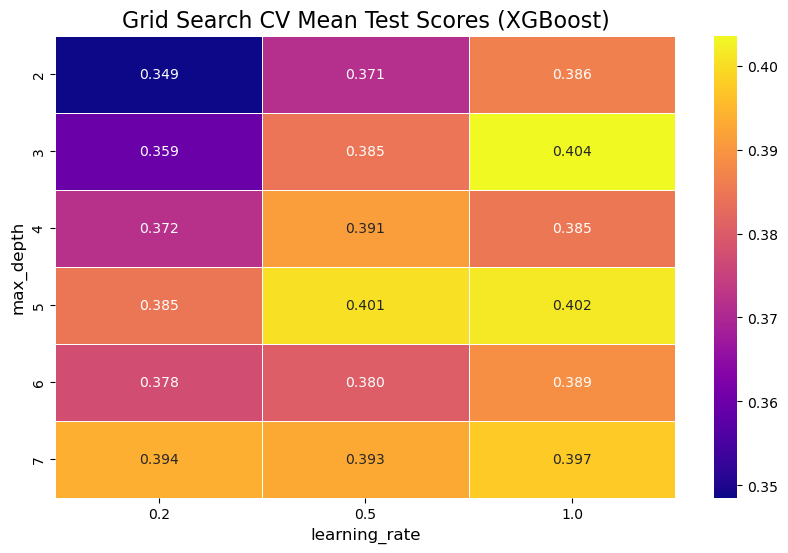

In [220]:
results = pd.DataFrame(grid.cv_results_)

# You can display the relevant columns to check
print("Grid Search Results DataFrame:")
print(results[['param_max_depth', 'param_learning_rate', 'mean_test_score']].head())
print("-" * 30)


# 2. Pivot the data to create the matrix for the heatmap
#    (The only change from the last example is 'param_n_estimators' -> 'param_learning_rate')
scores = results.pivot(index='param_max_depth', columns='param_learning_rate', values='mean_test_score')

print("Pivoted Scores for Heatmap:")
print(scores)
print("-" * 30)


# 3. Plot the heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(
    scores,
    annot=True,      # Show the scores in each cell
    fmt=".3f",       # Format the scores to 3 decimal places
    cmap='plasma',   # A different colormap for variety
    linewidths=.5
)
plt.title('Grid Search CV Mean Test Scores (XGBoost)', fontsize=16)
plt.xlabel('learning_rate', fontsize=12)
plt.ylabel('max_depth', fontsize=12)
plt.show()

In [221]:
best_xgb = grid.best_estimator_

In [222]:
data_train, data_val = train_test_split(available_data, test_size=0.2, shuffle=True)

X_tr = data_train[important_features]
y_tr = data_train[target]
X_val = data_val[important_features]
y_val = data_val[target]

#use for categorical data
y_tr = le.transform(y_tr)
y_val = le.transform(y_val)

best_xgb.fit(X_tr, y_tr)
preds = best_xgb.predict(X_val)
# plt.scatter(y_val, preds, alpha=.05)
# plt.xlabel('Observed y')
# plt.ylabel('Predicted y')
# plt.title('XGB predicted y vs. observed y on validation set')
# plt.show()

confusion_matrix(y_val, preds)

array([[  11,    0,  201],
       [   2,    2,   19],
       [  35,   10, 2347]])

In [223]:
f1_score(y_val, preds, average='macro')

0.3818209685723297

### ExplainableBoostingClassifier

In [ ]:
ebr = ExplainableBoostingClassifier(interactions=0)
ebr.fit(X,y)

show(ebr.explain_global())

## Notes

Does it make sense to do some batched feature reduction? E.g. for each of the following categories, the variables seem to be largely overlapping
- Location relative to landing: `BroadPhaseofFlight`, `altimiter`, `apt_dst`
- Aircraft type: `num_eng`, `acft_make`, `acft_category`, `acft_total_person_count`, `far_part`

`gust_kts` seems to be important but there's potentially a large amount of corrupted data in there. Should we keep it in?

How much do we have to worry about outliers if we're using a tree-based ensemble model?

Can try putting the categorical variables into XGBoost without one-hot encoding

I tried iteratively refining the list of important features and it seems like little changes on the second iteration

RandomForestRegressor hyperparameters
- Best max_depth = 7, similarly well for 6-9
- Best n_estimators = 200: the difference is marginal for anything above 50, and miniscule for anything above 200 (the difference seems to change trial-by-trial. Read: not statistically significant)

XGB does a bit better. Still not great.

XGB gets ~0.5 macro F1 on `damage` with 4 categrories, that goes down to ~0.4 if we drop the rows with unknown damage. Pretty bad!

`gust_kts` comes up as a fairly significant factor, but I'm a bit concerned about data leakage since we're missing a lot of the values. It seems plausible that gusts are more likely to be recorded when they're a factor, which may make them appear to be more important than they are

In [29]:
data.columns

Index(['ntsb_no', 'ev_type', 'ev_time', 'ev_country', 'ev_year', 'ev_month',
       'latitude', 'longitude', 'apt_dist', 'gust_kts', 'altimeter',
       'ev_highest_injury', 'ev_inj_tot_f', 'ev_inj_tot_m', 'ev_inj_tot_n',
       'ev_inj_tot_s', 'ev_inj_tot_t', 'aircraft_count', 'Aircraft_ID',
       'event_key', 'damage', 'num_eng', 'acft_fatal_count',
       'acft_minor_count', 'acft_none_count', 'acft_serious_count',
       'acft_total_person_count', 'acft_injured_person_count', 'insp_date',
       'event_date', 'days_since_insp', 'light_cond_DAYL', 'light_cond_DUSK',
       'light_cond_NDRK', 'light_cond_NITE', 'light_cond_other/unknown',
       'BroadPhaseofFlight_Air', 'BroadPhaseofFlight_Ground',
       'BroadPhaseofFlight_Landing', 'BroadPhaseofFlight_Takeoff',
       'BroadPhaseofFlight_other/unknown', 'eng_type_REC', 'eng_type_TF',
       'eng_type_TP', 'eng_type_TS', 'eng_type_other/unknown', 'far_part_091',
       'far_part_121', 'far_part_135', 'far_part_137', 'far_part_PUB

In [ ]:
## Approximate number of variables for each feature importance threshold
## This is old code that will no longer run, but the output would be very similar 

# alpha = np.arange(15)/100

# for a in alpha:
#    important_dummies = {item for item in feat_imps.items() if item[1] > a}
#    print(f'Importance threshold {a} -- {len(important_dummies)} variables')

Importance threshold 0.0 -- 47 variables
Importance threshold 0.01 -- 25 variables
Importance threshold 0.02 -- 8 variables
Importance threshold 0.03 -- 7 variables
Importance threshold 0.04 -- 6 variables
Importance threshold 0.05 -- 4 variables
Importance threshold 0.06 -- 4 variables
Importance threshold 0.07 -- 4 variables
Importance threshold 0.08 -- 4 variables
Importance threshold 0.09 -- 4 variables
Importance threshold 0.1 -- 4 variables
Importance threshold 0.11 -- 4 variables
Importance threshold 0.12 -- 3 variables
Importance threshold 0.13 -- 2 variables
Importance threshold 0.14 -- 2 variables


(array([11558.,    22.,    93.,   849.,   548.,   350.,   129.,    46.,
           32.,    12.]),
 array([ 0. ,  4.6,  9.2, 13.8, 18.4, 23. , 27.6, 32.2, 36.8, 41.4, 46. ]),
 <BarContainer object of 10 artists>)

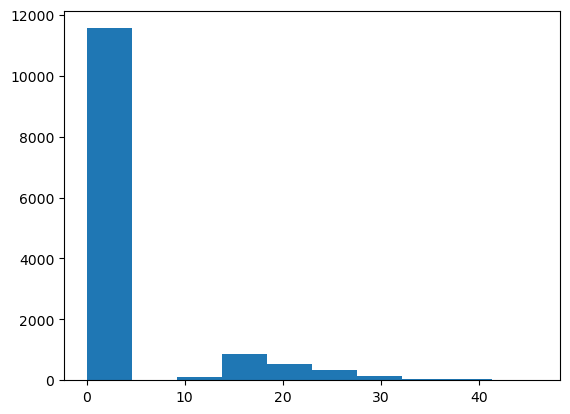

In [ ]:
# Histogram of `gust_kts`
# Restricted to < 50 to eliminate an outlier which is a clear mistake

plt.hist(injury_data[injury_data['gust_kts']<50]['gust_kts'])

In [46]:
injury_data['gust_kts'].max()

np.float64(999.0)

Grid Search Results DataFrame:
   param_max_depth  param_n_estimators  mean_test_score
0                2                 100         0.112324
1                2                 200         0.113401
2                2                 500         0.113690
3                4                 100         0.145664
4                4                 200         0.145004
------------------------------
Pivoted Scores for Heatmap:
param_n_estimators       100       200       500
param_max_depth                                 
2                   0.112324  0.113401  0.113690
4                   0.145664  0.145004  0.145550
6                   0.159535  0.160540  0.160041
8                   0.160781  0.161228  0.161549
10                  0.153751  0.154755  0.154405
------------------------------


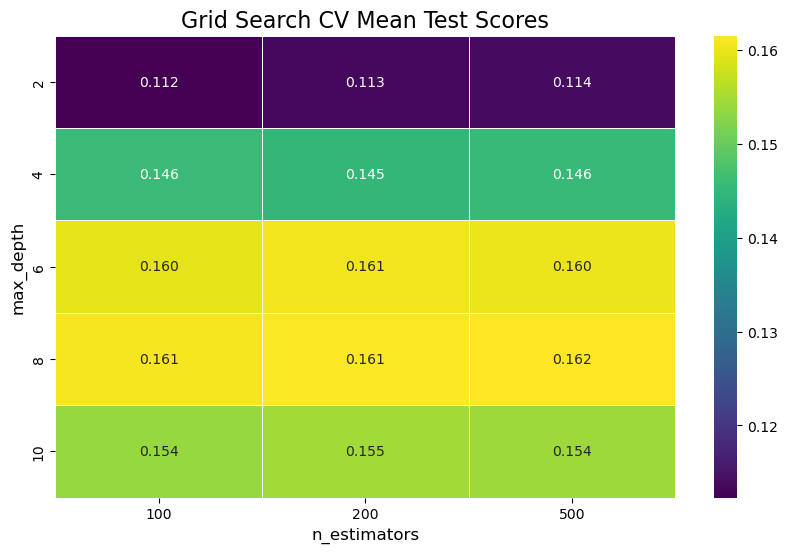

In [ ]:
## Heatmap of a grid search for parameters of a random forest to predict serious/fatal injury proportion
## Looks like increasing n_estimators doesn't accomplish much and it slows down the training/predicting
## Don't re-run, the variables have changed and the plot will look different

# results = pd.DataFrame(grid.cv_results_)

# # You can display the first few rows to see the structure
# print("Grid Search Results DataFrame:")
# print(results[['param_max_depth', 'param_n_estimators', 'mean_test_score']].head())
# print("-" * 30)

# # 2. Pivot the data to create a matrix with max_depth as rows and n_estimators as columns
# scores = results.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

# print("Pivoted Scores for Heatmap:")
# print(scores)
# print("-" * 30)


# # 3. Create the heatmap using seaborn
# plt.figure(figsize=(10, 6))
# sns.heatmap(
#     scores,
#     annot=True,      # Write the score in each cell
#     fmt=".3f",       # Format the annotations to 3 decimal places
#     linewidths=.5,   # Add lines between cells
#     cmap='viridis'   # Use a visually appealing color map
# )
# plt.title('Grid Search CV Mean Test Scores', fontsize=16)
# plt.xlabel('n_estimators', fontsize=12)
# plt.ylabel('max_depth', fontsize=12)
# plt.show()

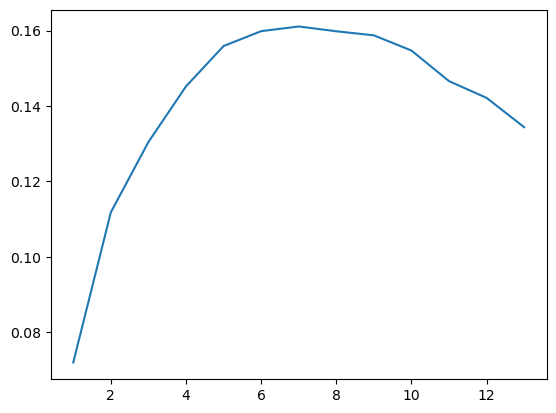

In [ ]:
## Plot of performance for n_estimators = 100, max_depth = 1,2,3,...,13
## Does best for max_depth = 6-9
## Don't re-run, the variables have changed and the plot will look different

# results = pd.DataFrame(grid.cv_results_)
# plt.plot(results['param_max_depth'], results['mean_test_score'])
# plt.show()